In [83]:
# Code:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

In [1]:
# Imports
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# Models
from torchvision.models import vgg19
from sys import path
path.append("../utils")
from models import LeNet5

In [2]:
parser = argparse.ArgumentParser("ATAC-GAN MNIST")

In [2]:
# Configs

cuda = True

n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
latent_dim=100
n_classes=10
img_size=28
channels=1
sample_interval=500

d_real_loss_coeff = 0.6
d_fake_loss_coeff = 0.4

adv_loss_coeff = 1
aux_loss_coeff = 1
tar_loss_coeff = .05

tar_loss_default = 22.2  # This is equal to the max possible tar_loss value

# target classifier conditional constants
adv_loss_threshold = 0.9
aux_loss_threshold = 1.465

lenet5_state_path = "../models/saves/MNIST_LeNet5"


In [3]:
def load_LeNet5():
    net = LeNet5()
    if cuda:
        net.cuda()
    
    # remove map location = cpu if using cuda
    net.load_state_dict(torch.load(lenet5_state_path, map_location=torch.device('cpu')))
    
    # set model to eval mode so nothing is changed
    net.eval()
    
    return net
    

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
# Models

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)
        self.target_label_emb = nn.Embedding(10, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels, target_labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        gen_input = torch.mul(self.target_label_emb(target_labels), gen_input)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 2#img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [7]:
# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()
target_classifier_loss = nn.CrossEntropyLoss() # negate target classifier output when passing to this loss function

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Load target classifier

target_classifier = load_LeNet5()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()
    target_classifier = target_classifier.cuda()
    target_classifier_loss = target_classifier_loss.cuda()

In [8]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [9]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [10]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "../images/%d.png" % batches_done, nrow=n_row, normalize=True)

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = Variable(LongTensor(np.array([num for _ in range(n_row) for num in range(n_row)])), requires_grad=False)
    target_labels = Variable(LongTensor(np.array([num for num in range(n_row) for _ in range(n_row)])), requires_grad=False)

    gen_imgs = generator(z, labels, target_labels)
    save_image(gen_imgs.data, "../images/%d.png" % batches_done, nrow=n_row, normalize=True)

def get_target_loss(adv_loss, aux_loss, target_classification, true_classification):
    #print(target_classification[0])
    if (adv_loss < adv_loss_threshold and aux_loss < aux_loss_threshold):
        return target_classifier_loss(target_classification * -1, true_classification)
    return Variable(FloatTensor([tar_loss_default]))

def test_attack(size):
    z = Variable(FloatTensor(np.random.normal(0, 1, (size, latent_dim))))
    gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, size)))
    imgs = generator(z, gen_labels)
    validity, pred_label = discriminator(imgs)
    

In [11]:
# Training
import csv
f = open('../models/RunSimple2_log.csv', 'a')
log_writer = csv.writer(f, delimiter=',')
log_writer.writerow(['Epoch', 'Batch', 'DLoss', 'DAcc', 'TarAcc', 'AdvLoss', 'AuxLoss', 'TarLoss', 'GLoss'])
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
        batch_size = imgs.shape[0]
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))
        g_target_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels, g_target_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        target_classifier_pred_label = target_classifier(gen_imgs)
        
        t_acc = np.mean(np.argmax(target_classifier_pred_label.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy())
        """
        adv_loss = adv_loss_coeff * adversarial_loss(validity, valid)
        aux_loss = aux_loss_coeff * auxiliary_loss(pred_label, gen_labels)
        tar_loss = tar_loss_coeff * target_classifier_loss(target_classifier_pred_label, gen_labels)
        """
        adv_loss = adversarial_loss(validity, valid)
        aux_loss = auxiliary_loss(pred_label, gen_labels)
        tar_loss = target_classifier_loss(target_classifier_pred_label, g_target_labels)
        #tar_loss = tar_loss_coeff * get_target_loss(adv_loss, aux_loss, target_classifier_pred_label, gen_labels)
        g_loss = adv_loss + 2*aux_loss + tar_loss
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid) + 2 * auxiliary_loss(real_aux, labels)

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = 2*adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)

        # Total discriminator loss
        #d_loss = d_real_loss_coeff * d_real_loss + d_fake_loss_coeff * d_fake_loss
        d_loss = d_real_loss + d_fake_loss

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()
        
        log_writer.writerow([epoch, i, d_loss.item(), 100*d_acc, 100*t_acc, adv_loss.item(), aux_loss.item(), tar_loss.item(), g_loss.item()])
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
            # Saves weights
            #torch.save(generator.state_dict(), "../models/SuccessSimple1_G")
            #torch.save(discriminator.state_dict(), "../models/SuccessSimple1_D")
            print(
                "=====================\nEpoch %d/%d, Batch %d/%d\nD loss: %f, acc: %d%% // tar acc: %d%% // G loss: %f, adv loss: %f, aux loss: %f, tar loss: %f"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, 100 * t_acc, g_loss.item(), adv_loss.item(), aux_loss.item(), tar_loss.item())
            )


/home/achyut/Projects/AdversarialRobustness/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0/200, Batch 0/938
D loss: 8.983235, acc: 9% // tar acc: 14% // G loss: 7.691808, adv loss: 0.697574, aux loss: 2.303187, tar loss: 2.387861
Epoch 0/200, Batch 500/938
D loss: 7.594349, acc: 42% // tar acc: 9% // G loss: 8.088058, adv loss: 1.498878, aux loss: 2.293571, tar loss: 2.002039
Epoch 1/200, Batch 62/938
D loss: 7.314465, acc: 50% // tar acc: 15% // G loss: 7.608746, adv loss: 1.692317, aux loss: 2.284657, tar loss: 1.347116
Epoch 1/200, Batch 562/938
D loss: 7.054468, acc: 43% // tar acc: 6% // G loss: 6.755088, adv loss: 1.607320, aux loss: 2.339187, tar loss: 0.469394
Epoch 2/200, Batch 124/938
D loss: 6.849772, acc: 54% // tar acc: 7% // G loss: 7.124305, adv loss: 1.655213, aux loss: 2.321585, tar loss: 0.825921
Epoch 2/200, Batch 624/938
D loss: 6.961403, acc: 53% // tar acc: 14% // G loss: 7.212965, adv loss: 1.899449, aux loss: 2.255187, tar loss: 0.803142
Epoch 3/200, Batch 186/938
D loss: 6.797661, acc: 52% // tar acc: 15% // G loss: 6.638948, adv loss: 1.6732

KeyboardInterrupt: 

In [43]:
# Saves weights
torch.save(generator.state_dict(), "../models/SuccessSimple2/G")
torch.save(discriminator.state_dict(), "../models/SuccessSimple2/D")

In [18]:
# Testing
batch_size = 1000
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
g_target_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

# Generate a batch of images
gen_imgs = generator(z, gen_labels, g_target_labels)

tensor(7, device='cuda:0')


NameError: name 'dpred_labels' is not defined

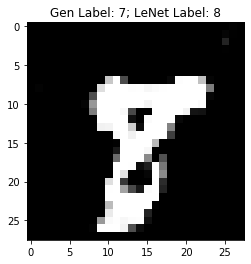

In [42]:
# Plots a sample
import matplotlib.pyplot as plt
sample_idx = 1
print(gen_labels[sample_idx])
plt.imshow(gen_imgs[sample_idx][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
plt.title("Gen Label: " + str(gen_labels.cpu().detach().numpy()[sample_idx]) + "; LeNet Label: " + str(np.argmax(pred_labels.data.cpu().numpy()[sample_idx])))
plt.xlabel("Discriminator Valid: " + str(validity.data.cpu().numpy()[sample_idx]) +" Discriminator Class: " + str(np.argmax(dpred_labels.data.cpu().numpy()[sample_idx])))

In [41]:
# Finds target classification for sample
pred_labels = target_classifier(gen_imgs)
np.argmax(pred_labels.data.cpu().numpy()[sample_idx])
#pred_labels.data.cpu().numpy()[sample_idx]

6

In [25]:
# Finds indexes that have adversarial examples
t_acc = np.argmax(pred_labels.data.cpu().numpy(), axis=1) == gen_labels.data.cpu().numpy()
np.where(t_acc == False)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         14,  15,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,  84,
         86,  88,  89,  90,  91,  92,  94,  95,  96,  97,  98,  99, 100,
        102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116,
        119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        134, 136, 137, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200, 201

KeyboardInterrupt: 

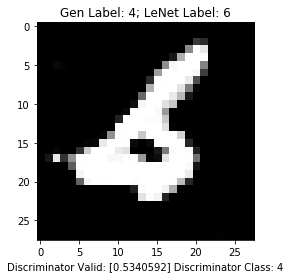

In [49]:
gen = gen_imgs.cpu().detach().numpy()
preds = pred_labels.data.cpu().numpy()
true = gen_labels.data.cpu().numpy()
v = validity.data.cpu().numpy()
dpred = dpred_labels.data.cpu().numpy()
for i in range(len(true)):
    if np.argmax(preds[i]) != true[i]:
        plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
        plt.xlabel("Discriminator Valid: " + str(v[i]) +" Discriminator Class: " + str(np.argmax(dpred[i])))
        plt.imshow(gen[i][0], cmap='gray')
        plt.savefig("../images/SimpleRun/AdversarialExamples/" + str(i) + ".png")
        
#for i in range(len(true)):
#    plt.title("Gen Label: " + str(true[i]) + "; LeNet Label: " + str(np.argmax(preds[i])))
#    plt.imshow(gen[i][0], cmap='gray')
#    plt.savefig("../images/SecondRun/AllSamples/" + str(i) + ".png")

In [39]:
# Extra saving
torch.save(gen_imgs, "../models/Success2_GenSample")
torch.save(gen_labels, "../models/Success2_GenLabels")
torch.save(pred_labels, "../models/Success2_LeNetLabels")

In [45]:
validity, dpred_labels = discriminator(gen_imgs)

/home/achyut/Projects/AdversarialRobustness/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
